# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [2]:
path = '..\data\parkinsons.data'
data = pd.read_csv(path, sep=',')

In [3]:
X = data.drop(columns=['name', 'status'])
y = data['status']

K - FOLD

In [4]:
# Thử từng k để chọn k tốt nhất.
# Chọn k lẻ vì bài toán có 2 lớp, tránh hòa phiếu
k_values = range(3, 22, 2)  # 3 -> 21
result = {}

# Bổ sung: Lưu kết quả chi tiết để tạo DataFrame
result_list = []

for k in k_values:
    f1_scores = []
    precision_scores = []
    recall_scores = []

    # lặp 100 mỗi k
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)

    for train_idx, test_idx in rskf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
        # StandardScaler chuẩn hóa theo công thức Z-score:
        #     X_scaled = (X - μ) / σ
        # Trong đó:
        #     - X: giá trị gốc
        #     - μ: trung bình của thuộc tính (mean)
        #     - σ: độ lệch chuẩn (standard deviation)
        # Kết quả: dữ liệu có mean = 0 và std = 1

        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test_scaled)

        f1 = f1_score(y_test, y_pred, average='binary')
        prec = precision_score(y_test, y_pred, average='binary')
        rec = recall_score(y_test, y_pred, average='binary')

        f1_scores.append(f1)
        precision_scores.append(prec)
        recall_scores.append(rec)

    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    mean_prec = np.mean(precision_scores)
    std_prec = np.std(precision_scores)
    mean_rec = np.mean(recall_scores)
    std_rec = np.std(recall_scores)

    result[k] = (mean_f1, std_f1)

    # Bổ sung để tạo bảng kết quả
    result_list.append({
        "k": k,
        "mean_f1": mean_f1,
        "std_f1": std_f1,
        "mean_precision": mean_prec,
        "std_precision": std_prec,
        "mean_recall": mean_rec,
        "std_recall": std_rec
    })

# Tìm k tốt nhất theo F1 trung bình
best_k_value, (best_mean_f1, best_std_f1) = max(result.items(), key=lambda x: x[1][0])

# Bổ sung: Tạo DataFrame kết quả và sắp xếp
result_df = pd.DataFrame(result_list)
result_df = result_df.sort_values(by="mean_f1", ascending=False).reset_index(drop=True)

SO SÁNH F1 TRUNG BÌNH VÀ ĐỘ LỆCH CHUẨN CỦA MÔ HÌNH KNN THEO K

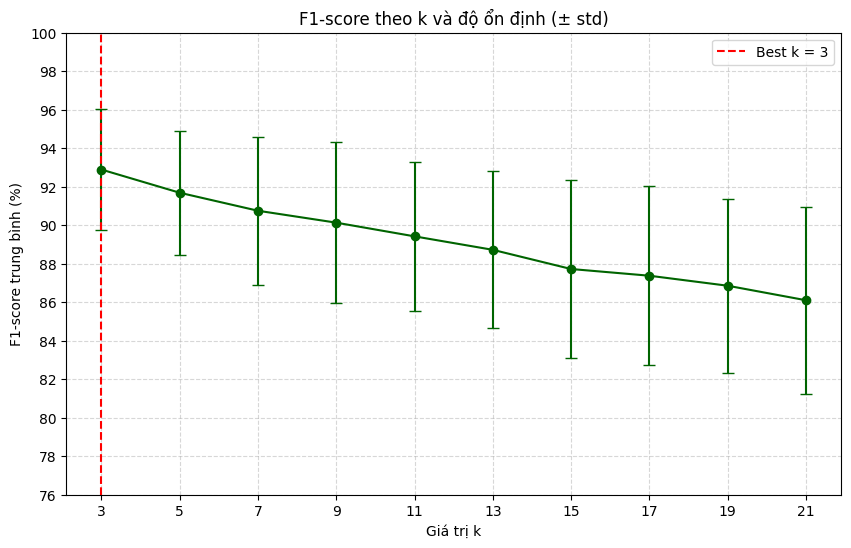

In [5]:
k_vals = list(result.keys())
means = [result[k][0] * 100 for k in k_vals]   # F1-score trung bình của từng lần lặp k
stds = [result[k][1] * 100 for k in k_vals]   # Độ lệch chuẩn F1 (%) của từng lần lặp k

plt.figure(figsize=(10, 6))
plt.errorbar(k_vals, means, yerr=stds, fmt='-o', capsize=4, color='darkgreen')
plt.axvline(best_k_value, color='red', linestyle='--', label=f'Best k = {best_k_value}')
plt.xlabel('Giá trị k')
plt.xticks(range(min(k_vals), max(k_vals)+1, 2))
plt.yticks(range(76, 101, 2))
plt.ylabel('F1-score trung bình (%)')
plt.title('F1-score theo k và độ ổn định (± std)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

ĐỘ CHÍNH XÁC CỦA MÔ HÌNH

In [8]:
result_df

,k,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
0,3,0.928924,0.031333,0.980879,0.025431,0.884299,0.054838
1,5,0.916877,0.032237,0.973230,0.028058,0.868989,0.056185
2,7,0.907523,0.038361,0.974393,0.031628,0.852552,0.066420
3,9,0.901331,0.041758,0.975860,0.028757,0.840678,0.069738
4,11,0.894219,0.038541,0.973521,0.030084,0.830092,0.066719
5,13,0.887222,0.040716,0.974528,0.031178,0.817793,0.069130
6,15,0.877252,0.046346,0.973878,0.031050,0.802149,0.077110
7,17,0.873770,0.046504,0.974399,0.031119,0.796356,0.077899
8,19,0.868569,0.045271,0.975840,0.031641,0.786828,0.076174
9,21,0.861032,0.048563,0.971586,0.034082,0.777299,0.077124
